<a href="https://colab.research.google.com/github/sanjib7777/Network_Security_Using_LSTM/blob/main/Network_security_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

In [3]:
df = pd.read_csv('/content/02-14-2018.csv')
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [4]:
selected_columns = {
    'Timestamp': 'Timestamp',
    'Destination_Port': 'Dst Port',
    'Flow_Duration': 'Flow Duration',
    'Network_Packets_Fwd': 'Tot Fwd Pkts',
    'Network_Packets_Bwd': 'Tot Bwd Pkts',
    'Fwd_Pkts_per_s': 'Fwd Pkts/s',
    'Bwd_Pkts_per_s': 'Bwd Pkts/s',
    'Bandwidth_Utilization': 'Flow Byts/s',
    'Network_Latency_Mean': 'Flow IAT Mean',
    'Network_Latency_Max': 'Flow IAT Max',
    'Connection_Attempts': 'SYN Flag Cnt',
    'Error_Rates': 'RST Flag Cnt',
    'Label':'Label'
}

# Create a new DataFrame with selected columns
df = df[list(selected_columns.values())].copy()

# Rename columns to more readable names
df.rename(columns={v: k for k, v in selected_columns.items()}, inplace=True)

In [5]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
df = df.replace([float('inf'), -float('inf')], float('nan'))
df = df.dropna()

In [7]:
df = df.drop_duplicates()

In [8]:
df.shape

(818763, 13)

In [9]:
df.isnull().sum()

,0
Timestamp,0
Destination_Port,0
Flow_Duration,0
Network_Packets_Fwd,0
Network_Packets_Bwd,0
Fwd_Pkts_per_s,0
Bwd_Pkts_per_s,0
Bandwidth_Utilization,0
Network_Latency_Mean,0
Network_Latency_Max,0


In [10]:
df.head()

,Timestamp,Destination_Port,Flow_Duration,Network_Packets_Fwd,Network_Packets_Bwd,Fwd_Pkts_per_s,Bwd_Pkts_per_s,Bandwidth_Utilization,Network_Latency_Mean,Network_Latency_Max,Connection_Attempts,Error_Rates,Label
0,14/02/2018 08:31:01,0,112641719,3,0,0.026633,0.000000,0.000000,5.632086e+07,56320958,0,0,Benign
1,14/02/2018 08:33:50,0,112641466,3,0,0.026633,0.000000,0.000000,5.632073e+07,56320814,0,0,Benign
2,14/02/2018 08:36:39,0,112638623,3,0,0.026634,0.000000,0.000000,5.631931e+07,56319525,0,0,Benign
3,14/02/2018 08:40:13,22,6453966,15,10,2.324152,1.549435,544.161528,2.689152e+05,673900,0,0,Benign
4,14/02/2018 08:40:23,22,8804066,14,11,1.590174,1.249423,380.733175,3.668361e+05,1928102,0,0,Benign


In [12]:
df['Label'].value_counts()

,count
Label,
Benign,662116
SSH-Bruteforce,117301
FTP-BruteForce,39346


In [13]:
# Ensure 'Timestamp' is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort the DataFrame by 'Timestamp'
df = df.sort_values(by='Timestamp').reset_index(drop=True)
df.head()

<ipython-input-13-b529bf3e7e73>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


,Timestamp,Destination_Port,Flow_Duration,Network_Packets_Fwd,Network_Packets_Bwd,Fwd_Pkts_per_s,Bwd_Pkts_per_s,Bandwidth_Utilization,Network_Latency_Mean,Network_Latency_Max,Connection_Attempts,Error_Rates,Label
0,1970-01-05 03:01:17,0,-11873000000,2,0,0.0,0.0,0.0,-1.187300e+10,-11873000000,0,0,Benign
1,1970-01-08 07:32:33,0,-681402000000,3,0,0.0,0.0,0.0,-3.407010e+11,-159438000000,0,0,Benign
2,1970-01-12 07:17:56,0,-919011000000,81,0,0.0,0.0,0.0,-1.148764e+10,754847000000,0,0,Benign
3,1970-01-12 09:15:10,0,-273850000000,282,0,0.0,0.0,0.0,-9.745552e+08,979781000000,0,0,Benign
4,1970-01-12 09:44:12,0,-529801000000,505,0,0.0,0.0,0.0,-1.051192e+09,948431000000,0,0,Benign


In [14]:
df['Label'] = df['Label'].replace(['SSH-Bruteforce', 'FTP-BruteForce'], 'Attack')

In [15]:
df['Label'].value_counts()

,count
Label,
Benign,662116
Attack,156647


In [31]:
df.head()

,Destination_Port,Flow_Duration,Network_Packets_Fwd,Network_Packets_Bwd,Fwd_Pkts_per_s,Bwd_Pkts_per_s,Bandwidth_Utilization,Network_Latency_Mean,Network_Latency_Max,Connection_Attempts,Error_Rates,Label
0,0,-11873000000,2,0,0.0,0.0,0.0,-1.187300e+10,-11873000000,0,0,1
1,0,-681402000000,3,0,0.0,0.0,0.0,-3.407010e+11,-159438000000,0,0,1
2,0,-919011000000,81,0,0.0,0.0,0.0,-1.148764e+10,754847000000,0,0,1
3,0,-273850000000,282,0,0.0,0.0,0.0,-9.745552e+08,979781000000,0,0,1
4,0,-529801000000,505,0,0.0,0.0,0.0,-1.051192e+09,948431000000,0,0,1


In [16]:
# Drop timestamp or transform it to a useful feature if needed
df = df.drop(columns=["Timestamp"])

# Encode label
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])  # Benign=0, Attack=1

In [17]:
from sklearn.model_selection import train_test_split
# Split features and label
X = df.drop(columns=['Label'])
y = df['Label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
y_test.shape

(163753,)

In [35]:
print(X_train[0])
print(y_train[0])


[-0.37670199 -0.00542528 -0.11268922 -0.05868552 -0.19595783 -0.20847151
 -0.07019302 -0.00513703 -0.00450759 -0.18226069 -0.23115023]
1


In [19]:
class NetworkDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [20]:
train_dataset = NetworkDataset(X_train, y_train)
test_dataset = NetworkDataset(X_test, y_test)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
# Model Architecture
class HybridModel(nn.Module):
    def __init__(self, input_dim):
        super(HybridModel, self).__init__()
        self.input_dim = input_dim
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=32, hidden_size=16, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN
        x = self.encoder(x)
        x = x.permute(0, 2, 1)  # Reshape for LSTM: [batch, seq, feature]
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Last hidden state [batch_size, hidden_size]
        out = self.fc(x)
        return out


In [23]:
# === Step 4: Training ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridModel(input_dim=X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/10, Loss: 275.7782
Epoch 2/10, Loss: 105.9223
Epoch 3/10, Loss: 76.8576
Epoch 4/10, Loss: 49.3786
Epoch 5/10, Loss: 31.2457
Epoch 6/10, Loss: 28.0816
Epoch 7/10, Loss: 25.1315
Epoch 8/10, Loss: 24.4852
Epoch 9/10, Loss: 23.8643
Epoch 10/10, Loss: 22.4072


In [25]:
# === Step 5: Evaluation ===
model.eval()
preds, labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())
        labels.extend(y_batch.numpy())

In [28]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# === Step 6: Additional Metrics ===
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

In [27]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9997
Precision: 0.9999
Recall: 0.9997
F1 Score: 0.9998


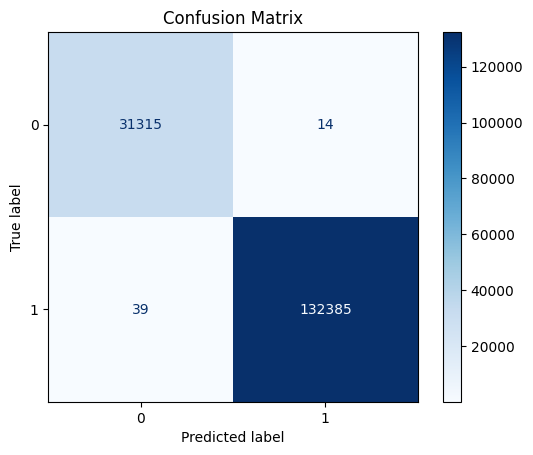

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Step 7: Confusion Matrix ===
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()